# Transport Footfall Forecasting using GCN-LSTM

This notebook adapts the Graph-Enhanced Temporal Network (GCN-LSTM) model from the DSSS coursework to forecast transport station footfall.
It compares the performance of the GCN-LSTM model against a baseline Pure LSTM model.

## 1. Import Libraries and Configure Device

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import copy
import warnings

# Configuration
SEED = 42
WINDOW_SIZE = 3
PREDICT_AHEAD = 1
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings('ignore')
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Load and Preprocess Transport Data

We load the merged footfall data and station coordinates. We'll focus on `EntryTapCount` as our target variable.
We pivot the data to get a matrix of shape `(Time Steps, Number of Stations)`.

In [2]:
# Paths
data_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/StationFootfall_Merged_2019-2023.csv'
coords_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/station_coords.csv'

# Load data
print("Loading data...")
df = pd.read_csv(data_path)
coords_df = pd.read_csv(coords_path)

# Convert TravelDate to datetime
df['TravelDate'] = pd.to_datetime(df['TravelDate'])

# Filter out stations without coordinates
stations_with_coords = coords_df.dropna(subset=['latitude', 'longitude'])['Station'].unique()
df = df[df['Station'].isin(stations_with_coords)]

# Pivot data: Index=Date, Columns=Station, Values=EntryTapCount
# We aggregate by date and station (summing over time of day if any, though data seems daily)
pivot_df = df.pivot_table(index='TravelDate', columns='Station', values='EntryTapCount', aggfunc='sum')

# Fill missing values (if any) with 0 or interpolation
pivot_df = pivot_df.fillna(0)

# Sort index
pivot_df = pivot_df.sort_index()

# Get list of stations (nodes)
stations = pivot_df.columns.tolist()
num_stations = len(stations)

print(f"Data shape: {pivot_df.shape}")
print(f"Number of stations: {num_stations}")
print(f"Date range: {pivot_df.index.min()} to {pivot_df.index.max()}")

# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(pivot_df.values)

# Convert to tensor
data_tensor = torch.FloatTensor(data_normalized)
print("Data normalized and converted to tensor.")

Loading data...
Data shape: (1826, 414)
Number of stations: 414
Date range: 2019-01-01 00:00:00 to 2023-12-31 00:00:00
Data normalized and converted to tensor.


## 3. Construct Spatial Graph from Coordinates

We build an adjacency matrix based on geographical distance. Stations within a certain distance threshold are connected.

In [3]:
def create_distance_adjacency_matrix(stations, coords_df, threshold_km=5.0):
    n = len(stations)
    adj = np.zeros((n, n))
    
    # Create a dictionary for fast lookup
    coords_dict = coords_df.set_index('Station')[['latitude', 'longitude']].to_dict('index')
    
    print(f"Calculating pairwise distances for {n} stations (Threshold: {threshold_km} km)...")
    
    for i in range(n):
        for j in range(i + 1, n):
            s1 = stations[i]
            s2 = stations[j]
            
            if s1 in coords_dict and s2 in coords_dict:
                loc1 = (coords_dict[s1]['latitude'], coords_dict[s1]['longitude'])
                loc2 = (coords_dict[s2]['latitude'], coords_dict[s2]['longitude'])
                
                dist = geodesic(loc1, loc2).km
                
                if dist <= threshold_km:
                    adj[i, j] = 1
                    adj[j, i] = 1
                    
    # Add self-loops
    np.fill_diagonal(adj, 1)
    return adj

# Build adjacency matrix
adj_matrix = create_distance_adjacency_matrix(stations, coords_df, threshold_km=2.0) # Using 2km threshold for denser London network
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Average degree: {adj_matrix.sum(axis=1).mean():.2f}")

def process_adj_matrix(adj):
    # Add self-loops (already added, but good to ensure)
    adj_with_self = adj + np.eye(adj.shape[0])
    adj_with_self[adj_with_self > 1] = 1 # Clip to 1

    # Compute the degree matrix
    degrees = np.array(adj_with_self.sum(1))

    # Compute D^(-1/2)
    # Handle division by zero if any isolated node (though self-loop prevents it)
    with np.errstate(divide='ignore'):
        D_inv_sqrt = np.power(degrees, -0.5)
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.
    D_inv_sqrt = np.diag(D_inv_sqrt.flatten())

    # Compute normalized adjacency: D^(-1/2) * A * D^(-1/2)
    normalized_adj = D_inv_sqrt.dot(adj_with_self).dot(D_inv_sqrt)

    return normalized_adj

# Normalize adjacency matrix
A_hat = process_adj_matrix(adj_matrix)
print("Adjacency matrix normalized.")

Calculating pairwise distances for 414 stations (Threshold: 2.0 km)...
Adjacency matrix shape: (414, 414)
Average degree: 9.88
Adjacency matrix normalized.


## 4. Create Sliding Window Sequences

We define a `TransportDataset` class to create sliding window sequences for training.
We split the data chronologically: 70% Train, 15% Validation, 15% Test.

In [4]:
class TransportDataset(Dataset):
    def __init__(self, data_tensor, window_size, predict_ahead=1):
        self.data = data_tensor
        self.window_size = window_size
        self.predict_ahead = predict_ahead
        
        # Number of possible windows
        self.num_samples = len(data_tensor) - window_size - predict_ahead + 1
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Input: [window_size, num_stations]
        X = self.data[idx : idx + self.window_size]
        
        # Target: [num_stations] (at time t + predict_ahead)
        y = self.data[idx + self.window_size + self.predict_ahead - 1]
        
        return X, y

# Create full dataset
full_dataset = TransportDataset(data_tensor, WINDOW_SIZE, PREDICT_AHEAD)

# Split indices
total_samples = len(full_dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

indices = list(range(total_samples))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 1276
Val samples: 273
Test samples: 274


## 5. Define GCN-LSTM and Baseline Architectures

We define the `GraphConvLayer`, `TemporalAttention`, `GCN_LSTM`, and `PureLSTM` classes.
These are adapted from the DSSS coursework to work with our transport data.

In [5]:
# Graph Convolutional Layer
class GraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(GraphConvLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        input = self.dropout(input)
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        return output

# Temporal Attention Mechanism
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.W = nn.Parameter(torch.zeros(size=(hidden_dim, hidden_dim)))
        nn.init.xavier_uniform_(self.W.data)
        self.w = nn.Parameter(torch.zeros(size=(hidden_dim, 1)))
        nn.init.xavier_uniform_(self.w.data)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size, window_size, num_nodes, hidden_dim = x.size()
        x_flat = x.view(-1, hidden_dim)
        u = self.tanh(torch.matmul(x_flat, self.W))
        att = torch.matmul(u, self.w)
        att = att.view(batch_size, window_size, num_nodes)
        att = self.softmax(att)
        att = att.unsqueeze(-1)
        output = x * att
        output = output.sum(dim=1)
        return output

# GCN-LSTM Model
class GCN_LSTM(nn.Module):
    def __init__(self, window_size, num_nodes, hidden_dim=32, out_dim=1, lambda_mmd=0.1, dropout=0.1):
        super(GCN_LSTM, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.lambda_mmd = lambda_mmd
        
        # Feature dim is 1 (EntryTapCount)
        self.feature_dim = 1
        
        self.spatial_embedding = nn.Linear(self.feature_dim, hidden_dim)
        self.gc1 = GraphConvLayer(hidden_dim, hidden_dim, dropout)
        self.gc2 = GraphConvLayer(hidden_dim, hidden_dim, dropout)
        self.temporal_attention = TemporalAttention(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        batch_size = x.size(0)
        x = x.unsqueeze(-1) # [Batch, Window, Nodes, 1]
        
        outputs = []
        initial_embedding = None
        
        for t in range(self.window_size):
            x_t = x[:, t, :, :]
            h_t = self.spatial_embedding(x_t)
            
            if t == 0:
                initial_embedding = h_t
            
            # Apply GCN layers (batch-wise)
            # Note: In DSSS code, they looped over batch. Here we can optimize if adj is static.
            # But to keep strictly to DSSS logic:
            h_t_list = []
            for b in range(batch_size):
                h_b = h_t[b]
                h_b = self.gc1(h_b, adj)
                h_b = self.relu(h_b)
                h_b = self.gc2(h_b, adj)
                h_b = self.relu(h_b)
                h_t_list.append(h_b.unsqueeze(0))
            
            h_t = torch.cat(h_t_list, dim=0)
            outputs.append(h_t.unsqueeze(1))
            
        h = torch.cat(outputs, dim=1)
        h = self.temporal_attention(h)
        final_embedding = h
        out = self.fc_out(h).squeeze(-1)
        
        mmd = self.maximum_mean_discrepancy(initial_embedding, final_embedding)
        return out, mmd

    def maximum_mean_discrepancy(self, x, y):
        x = x.mean(dim=1)
        y = y.mean(dim=1)
        def gaussian_kernel(a, b, sigma=1.0):
            dist = torch.sum((a.unsqueeze(1) - b.unsqueeze(0)).pow(2), dim=2)
            return torch.exp(-dist / (2 * sigma**2))
        xx = gaussian_kernel(x, x)
        yy = gaussian_kernel(y, y)
        xy = gaussian_kernel(x, y)
        return torch.mean(xx) + torch.mean(yy) - 2 * torch.mean(xy)

# Pure LSTM Baseline
class PureLSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim=32, num_layers=1, dropout=0.1):
        super(PureLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [Batch, Window, Nodes]
        batch_size, window_size, num_nodes = x.size()
        
        # Reshape for LSTM: Treat each node as a separate sequence in the batch?
        # Or treat all nodes as features? DSSS treats each node as part of a larger batch dimension.
        # Reshape to [Batch * Nodes, Window, 1]
        x = x.permute(0, 2, 1).contiguous().view(batch_size * num_nodes, window_size, 1)
        
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        last_output = self.dropout(last_output)
        output = self.fc(last_output)
        
        # Reshape back to [Batch, Nodes]
        output = output.view(batch_size, num_nodes)
        return output

## 6. Train GCN-LSTM and Pure LSTM Models

We implement training loops for both models.
- **GCN-LSTM**: Uses MSE Loss + MMD Regularization.
- **Pure LSTM**: Uses MSE Loss.

In [6]:
def train_gcn_lstm(model, train_loader, val_loader, adj, epochs, lr, patience, device):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    adj_tensor = torch.tensor(adj, dtype=torch.float32, device=device)
    
    best_loss = float('inf')
    patience_counter = 0
    best_state = None
    
    train_losses = []
    val_losses = []
    
    print("Starting GCN-LSTM Training...")
    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds, mmd = model(X, adj_tensor)
            loss = criterion(preds, y) + model.lambda_mmd * mmd
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)
        
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds, _ = model(X, adj_tensor)
                loss = criterion(preds, y)
                batch_val_losses.append(loss.item())
        
        avg_val_loss = np.mean(batch_val_losses)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
    model.load_state_dict(best_state)
    return model, train_losses, val_losses

def train_pure_lstm(model, train_loader, val_loader, epochs, lr, patience, device):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    
    best_loss = float('inf')
    patience_counter = 0
    best_state = None
    
    train_losses = []
    val_losses = []
    
    print("Starting Pure LSTM Training...")
    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)
        
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                batch_val_losses.append(loss.item())
        
        avg_val_loss = np.mean(batch_val_losses)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
    model.load_state_dict(best_state)
    return model, train_losses, val_losses

# Initialize models
gcn_lstm = GCN_LSTM(window_size=WINDOW_SIZE, num_nodes=num_stations, hidden_dim=32, lambda_mmd=0.01)
pure_lstm = PureLSTM(num_nodes=num_stations, hidden_dim=32)

# Train GCN-LSTM
gcn_lstm, gcn_train_loss, gcn_val_loss = train_gcn_lstm(
    gcn_lstm, train_loader, val_loader, A_hat, EPOCHS, 0.001, PATIENCE, DEVICE
)

# Train Pure LSTM
pure_lstm, lstm_train_loss, lstm_val_loss = train_pure_lstm(
    pure_lstm, train_loader, val_loader, EPOCHS, 0.001, PATIENCE, DEVICE
)

Starting GCN-LSTM Training...
Epoch 1/50 - Train Loss: 0.072148, Val Loss: 0.037532
Epoch 2/50 - Train Loss: 0.050145, Val Loss: 0.039061
Epoch 3/50 - Train Loss: 0.048241, Val Loss: 0.036704
Epoch 4/50 - Train Loss: 0.046405, Val Loss: 0.035981
Epoch 5/50 - Train Loss: 0.044587, Val Loss: 0.036632
Epoch 6/50 - Train Loss: 0.044386, Val Loss: 0.035664
Epoch 7/50 - Train Loss: 0.043306, Val Loss: 0.035718
Epoch 8/50 - Train Loss: 0.042738, Val Loss: 0.035567
Epoch 9/50 - Train Loss: 0.042618, Val Loss: 0.035420
Epoch 10/50 - Train Loss: 0.042289, Val Loss: 0.035318
Epoch 11/50 - Train Loss: 0.041694, Val Loss: 0.035334
Epoch 12/50 - Train Loss: 0.041526, Val Loss: 0.035386
Epoch 13/50 - Train Loss: 0.041406, Val Loss: 0.035756
Epoch 14/50 - Train Loss: 0.040882, Val Loss: 0.035466
Epoch 15/50 - Train Loss: 0.040808, Val Loss: 0.035421
Early stopping at epoch 15
Starting Pure LSTM Training...
Epoch 1/50 - Train Loss: 0.136402, Val Loss: 0.044352
Epoch 2/50 - Train Loss: 0.046457, Val Los

## 7. Evaluate and Visualize Predictions

We evaluate both models on the test set and visualize the results for top stations.

Pure LSTM Metrics: {'MAE': 2412.468994140625, 'RMSE': np.float64(5076.630378508958), 'R2': -1.089374303817749}
GCN-LSTM Metrics: {'MAE': 1653.80029296875, 'RMSE': np.float64(3671.3590126818162), 'R2': 0.1005469411611557}


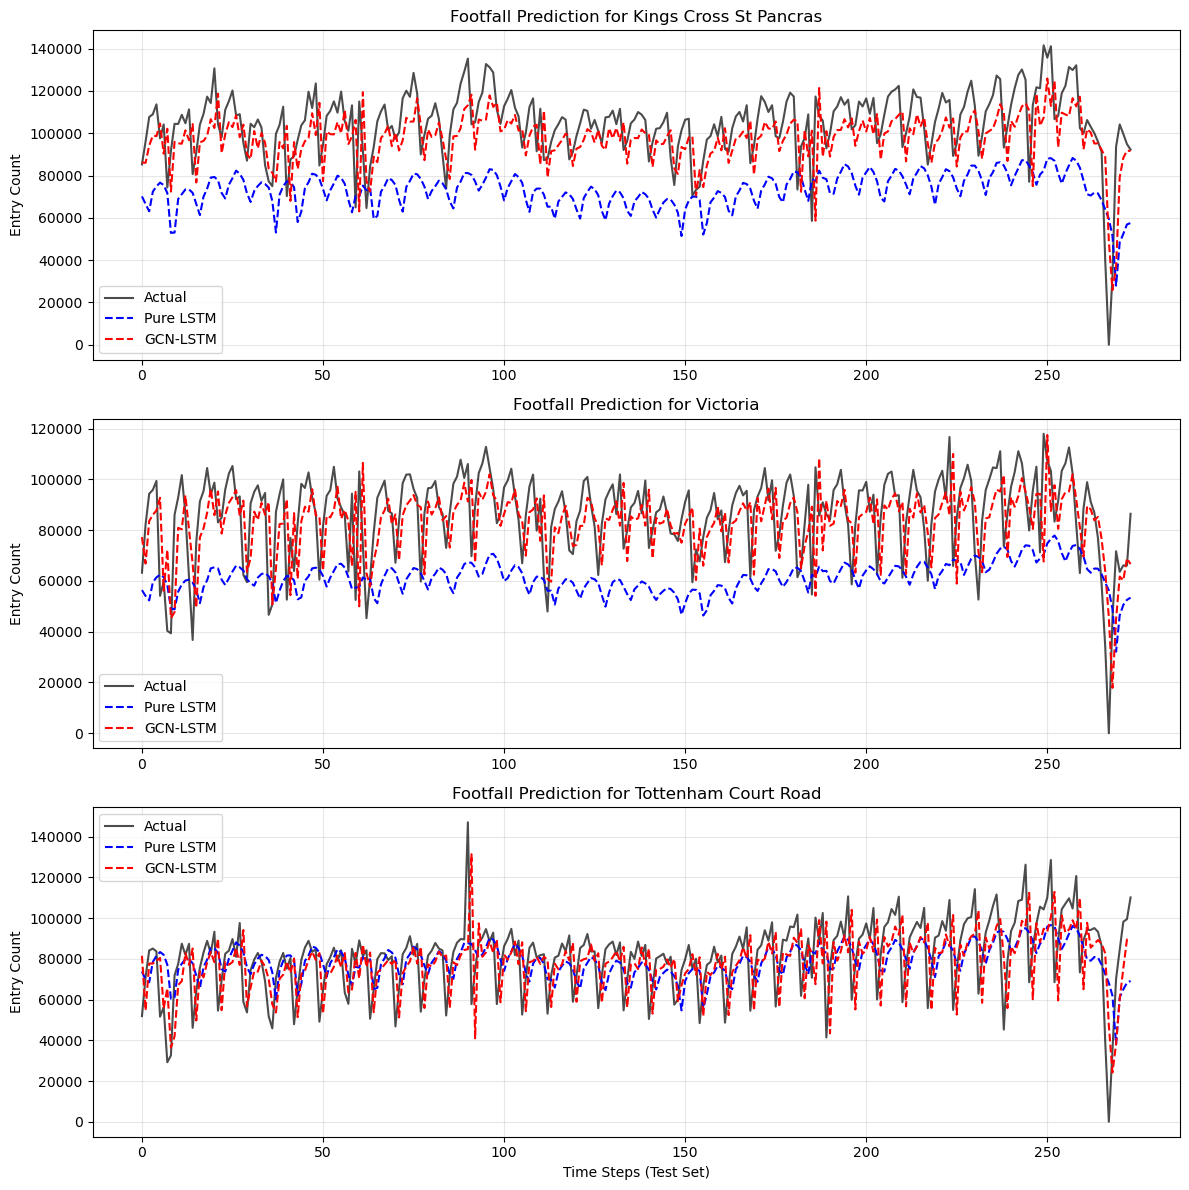

In [12]:
def evaluate_model(model, test_loader, adj, device, is_gcn=True):
    model.eval()
    all_preds = []
    all_targets = []
    
    adj_tensor = torch.tensor(adj, dtype=torch.float32, device=device) if adj is not None else None
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if is_gcn:
                preds, _ = model(X, adj_tensor)
            else:
                preds = model(X)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
            
    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Inverse transform to get actual counts
    preds_inv = scaler.inverse_transform(preds)
    targets_inv = scaler.inverse_transform(targets)
    
    mae = mean_absolute_error(targets_inv, preds_inv)
    rmse = np.sqrt(mean_squared_error(targets_inv, preds_inv))
    r2 = r2_score(targets_inv, preds_inv)
    
    return preds_inv, targets_inv, {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Evaluate GCN-LSTM
gcn_preds, targets, gcn_metrics = evaluate_model(gcn_lstm, test_loader, A_hat, DEVICE, is_gcn=True)
print("Pure LSTM Metrics:", gcn_metrics)

# Evaluate Pure LSTM
lstm_preds, _, lstm_metrics = evaluate_model(pure_lstm, test_loader, None, DEVICE, is_gcn=False)
print("GCN-LSTM Metrics:", lstm_metrics)

# Visualization
def plot_predictions(targets, gcn_preds, lstm_preds, stations, num_stations_to_plot=3):
    # Select top stations by volume
    total_volume = targets.sum(axis=0)
    top_indices = np.argsort(total_volume)[-num_stations_to_plot:][::-1]
    
    fig, axes = plt.subplots(num_stations_to_plot, 1, figsize=(12, 4 * num_stations_to_plot))
    if num_stations_to_plot == 1: axes = [axes]
    
    for i, idx in enumerate(top_indices):
        station_name = stations[idx]
        ax = axes[i]
        
        ax.plot(targets[:, idx], label='Actual', color='black', alpha=0.7)
        ax.plot(gcn_preds[:, idx], label='Pure LSTM', color='blue', linestyle='--')
        ax.plot(lstm_preds[:, idx], label='GCN-LSTM', color='red', linestyle='--')
        
        ax.set_title(f"Footfall Prediction for {station_name}")
        ax.set_ylabel("Entry Count")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    plt.xlabel("Time Steps (Test Set)")
    plt.tight_layout()
    plt.show()

plot_predictions(targets, gcn_preds, lstm_preds, stations)